# Sparse dictionnary learning

## Chargement des données Olivetti Faces

Ce dataset contient les images de 40 visages de personnes distinctes prises à différents instants, en variant la luminosité ainsi que les expressions faciale (sourire, yeux ouverts ou fermés, lunettes...).

L'objectif est détudier la décomposition de ces informations en signaux "sparses" à l'aide du Sparse Coding. 

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

# On charge la base de photos de visages
data = fetch_olivetti_faces()
# Le format actuel est (nombre_images, largeur, hauteur), nous devons le transformer en (nombre_images, largeur * hauteur)
x_train = data.images.reshape(400, 64*64)
targets = data.target

* Visualisation des données

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 4):
    n_images = len(images)
    titles = ['Personne (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title, fontsize=100)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
img_list = []
target_list = []
for i in range(0, len(targets), 10):
    img_list.append(x_train[i].reshape(64, 64))
    target_list.append(str(targets[i]))

print("Nombre de personnes différentes : ", np.max(targets))
print("Exemples : ")
show_images(img_list, 4)


Nombre de personnes différentes :  39
Exemples : 


## Application de l'algorithme 

On utilise la librairie scikit-learn pour appliquer le Sparse coding sur les données d'entraînement
* D'abord, il est nécessaire d'apprendre le dictionnaire de représentation (dit d'atomes) des données

_*Contrainte de parcimonie : Le nombre de composants d'un atome doit être supérieur au nombre de pixels d'une image*_
* Puis on applique un Sparse Coder pour projeter les données d'entrées selon une comninaison linéaire parcimonieuse des atomes du dictionnaire

__Fonctionnement :__

On cherche à minimiser la fonction de perte suivante : ![Equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/7c6bd5bd1d98ea77b82ca8fd604d3508798ccc51 "Sparse coding equation")


Avec

D : Dictionnaire d'atomes

alpha : Vecteur parcimonieux (nombre important de composantes nulles) représentant une image

lambda : paramètre de régularisation qui contrôle la parcimonie de la solution

La norme l1 (ou distance de Manhattan) de x est notée ![Norme](https://wikimedia.org/api/rest_v1/media/math/render/svg/2ea33fdb26c26b8aff9cee539b05be5bbefc36cb "Distance de Manhattan")


In [3]:
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder

#Attention, le paramètre alpha utilisé par sklearn est bien le paramètre de régularisation
# => soit lambda dans la formule ci-dessus
atoms_dict = MiniBatchDictionaryLearning(n_components=6400, alpha=5, n_iter=5)

#On fit le dictionnaire sur les données d'entrée
D = atoms_dict.fit(x_train).components_

#Puis on instancie et fit le Sparse Coder sur le dictionnaire appris
coder = SparseCoder(dictionary=D, transform_algorithm='lasso_lars')

x_train_sparse = coder.fit_transform(x_train)


Nous avons bien créé une représentation parcimonieuse des données d'entrée en combinant un dictionnaire "overcomplete" (qui contient plus de dimensions que les données qu'il représente) et d'un vecteur Sparse.

Pour plus de détail concernant l'algorithme et son implémentation, voir [Online dictionary learning for sparse coding, Mairal et al.](https://www.di.ens.fr/sierra/pdfs/icml09.pdf)

# Visualisation des features apprises

On visualise d'abord le dictionnaire d'atomes appris

Taille du dictionnaire appris :  (6400, 4096)
Taille de l'ensemble d'entraînement transformé :  (400, 6400)
Visualisation d'une image:


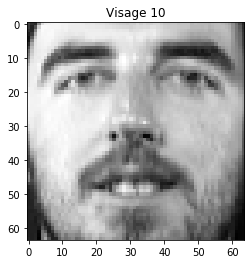

Code sparse:


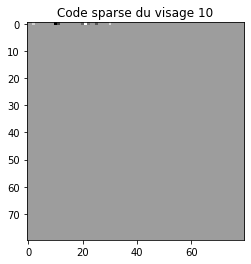

Un élément du dictionnaire appris:


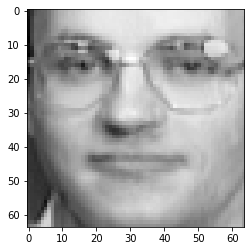

Représentation du visage 10 re-construit à l'aide du dictionnaire et du code:


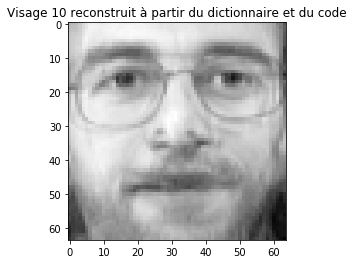

In [4]:
print("Taille du dictionnaire appris : ", D.shape)

print("Taille de l'ensemble d'entraînement transformé : ", x_train_sparse.shape)

print("Visualisation d'une image:")
plt.title("Visage %d"%targets[100])
plt.imshow(x_train[100].reshape(64, 64), cmap='gray')
plt.show()

print("Code sparse:")
plt.title("Code sparse du visage %d"%targets[100])
plt.imshow(x_train_sparse[100].reshape(80, 80), cmap='gray')
plt.show()

print("Un élément du dictionnaire appris:")
plt.imshow(D[0].reshape(64, 64), cmap='gray')
plt.show()

print("Représentation du visage %d re-construit à l'aide du dictionnaire et du code:"%targets[100])
plt.title("Visage %d reconstruit à partir du dictionnaire et du code"%targets[100])
# La représentation d'une image se calcule en faisant le produit matriciel de la transposée du dictionnaire
# avec le code sparse de l'image choisie
visage_reconstruit = np.matmul(np.transpose(D),  x_train_sparse[100]).reshape(64, 64)

plt.imshow(visage_reconstruit, cmap='gray')
plt.show()

On remarque que l'erreur de reconstruction est élevée : le visage reconstruit ressemble peu à celui souhaité (il semble être une combinaison de plusieurs visages du dataset). 

Raison : Nous avons utilisé l'algorithme MiniBatchDictionaryLearning pour apprendre le dictionnaire qui a pour particularité d'utiliser seulement un sous-ensemble du dataset à chaque itération pour résoudre le problème d'optimisation ci-dessus. 
Ici, nous n'avons fait que 5 itération, ce qui a rendu l'apprentissage incomplet et la représentation peu ressemblante. 

A tester : Faire varier les paramètres du MiniBatchDictionaryLearning et du SparseCoder et augmenter le nombre d'itérations (attention, l'opération peut être longue). La liste des paramètres peut être trouvée aux url suivantes :

- [Documentation MiniBatchDictionaryLearning](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html#sklearn.decomposition.DictionaryLearning)

- [Documentation SparseCoder](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparseCoder.html#sklearn.decomposition.SparseCoder)

Essayez vous-même :)